In [1]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
from utils import simplex_content
from ddsl import *

In [2]:
import numpy as np
# random hull
def reorder(v, e):
    e_list = [list(e[0])]
    e_finish = [0]

    for i in range(1, e.shape[0]):
        p = e_list[-1][-1]
        loc = np.stack(np.where(e == p), axis=-1)
        if loc[0, 0] in np.array(e_finish):
            l = 1
        else:
            l = 0
        e_finish.append(loc[l, 0])
        n = int(e[loc[l, 0]].sum()-p)
        e_list.append([p, n])

    return np.array(e_list)
        
def rand_hull(n_points, dim, hull=False, dtype=torch.float32):
    V = np.random.rand(n_points, dim)
    if not hull:
        mesh = Delaunay(V)
        E = mesh.simplices
    else:
        mesh = ConvexHull(V)
        E = mesh.simplices
        E = reorder(V, E)
    V, E = torch.tensor(V, dtype=dtype), torch.LongTensor(E)
    # normalize V
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

In [3]:
dim = 2
j = 0
npoints = 30
r = 128
hull = j == 1

V, E = rand_hull(npoints, dim, hull=hull, dtype=torch.float64)
V += 1e-3 * torch.rand(V.shape, dtype=V.dtype, device=V.device)
if j == 0:
    E = torch.arange(V.shape[0], device=V.device).unsqueeze(-1)
D = torch.ones(E.shape[0], 1, dtype=V.dtype)
# D = torch.rand(E.shape[0], 1, dtype=V.dtype)
V.requires_grad = False

res = [r] * dim
t = [1] * dim

V, E, D = V.cuda(), E.cuda(), D.cuda()

ddsl = DDSL(res, t, j, 10, "density")
from time import time
t0 = time()
F = ddsl(V, E, D)
print("Time Lapse: {}".format(time() - t0))
torch.cuda.empty_cache()

Time Lapse: 0.004868507385253906


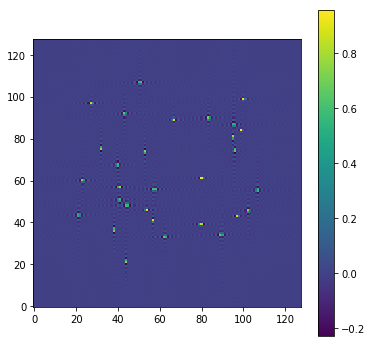

In [4]:
F = F.squeeze()
if torch.sum(torch.isnan(F)) > 0:
    nnan = torch.sum(torch.isnan(F))
    F[torch.isnan(F)] = 0
    print("Padding {} nan terms to zero.".format(nnan))

F_ = F.cpu().detach().numpy()
f_ = torch.irfft(F, dim, signal_sizes=res).squeeze().cpu().detach().numpy()
plt.figure(figsize=(6,6))
# plt.imshow(f_[:, 32, :])
plt.imshow(f_.T, origin='lower')

# plt.imshow(np.fft.ifftshift(F_[:, :, 16, 0], [0,1]))
plt.colorbar()
plt.show()

In [ ]:
from utils import construct_B, batch_adjugate
print(V.shape, E.shape)
B = construct_B(V, E)
B_adj = batch_adjugate(B)
print(B_adj[0])
print(B[0])

In [ ]:
points = V.cpu().numpy()
simplices = E.cpu().numpy()
plt.triplot(points[:,0], points[:,1], simplices.copy())
plt.axis('equal')
plt.show()